# CFRM 521: Predicting Cointegration in Cryptocurrency Prices

## Group 6: Alex Thompson, Ryan Johnson, Griffin Collins

## Introduction

One popular trading strategy is pairs trading, whereby two assets that move at a similar trajectory are traded when a discrepancy in price is detected. For example, suppose the price of Pepsi stock is typically two times the price of Coca Cola stock, but you see one day that the ratio of prices is not two but three. This suggests that Pepsi is overpriced and Coca Cola is underpriced, so you sell Pepsi stock and buy Coca Cola stock, then hold until the multiple of two is reestablished. 

This assumes that the pairs will move back to their long-run "spread" after some amount of time. However, it is not guaranteed that the prices will maintain their relationship, and predicting whether or not they do is the goal of this project.

## Cryptocurrencies

We chose to use cryptocurrencies because they are traded at all times (providing a more continuous time frame), it is easy to get very granular data, and because there is much interest in the area right now generally speaking. The data comes from the Binance exchange and is downloaded using [their API](https://github.com/binance-exchange/binance-official-api-docs/blob/master/rest-api.md). For this project, we look at relationships quoted in USD, but data is available quoted in Bitcoin (BTC) and other cryptocurrencies as well. The primary relationship we look at is that between Bitcoin (BTC) and Ethereum (ETH) prices.

### Data

For convenience, I have packaged much of the code I use on this project into a module. The data from Binance is in 15 minute intervals and filtered to cryptocurrencies with at least 30,000 observations.

In [4]:
import sys

project_dir = '/Users/alex/ml_class/project/'

sys.path.append(project_dir)

In [5]:
from core.utils import get_dfs, get_good_dfs, get_close_prices
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

dfs = get_dfs("../data")
good_dfs = get_good_dfs(dfs, 30000)
closes = get_close_prices(good_dfs)
closes.head()

,ZECETH,TRXETH,XRPETH,BNBBTC,EOSETH,LTCBNB,ADABTC,EOSBNB,LTCETH,XRPBNB,...,EOSBTC,BNBETH,XRPBTC,DASHBTC,EOSUSDT,XMRBTC,ADAETH,ADAUSDT,XRPUSDT,LTCBTC
time,,,,,,,,,,,,,,,,,,,,,
2018-06-11 11:30:00+00:00,0.37205,0.000090,0.001085,0.002203,0.021298,7.17,0.000026,0.7636,0.20085,0.03872,...,0.001677,0.027988,0.000085,0.040191,11.3498,0.020349,0.000325,0.17274,0.57663,0.015782
2018-06-11 11:45:00+00:00,0.37247,0.000090,0.001084,0.002211,0.021300,7.15,0.000026,0.7600,0.20050,0.03882,...,0.001680,0.028056,0.000085,0.040079,11.3799,0.020455,0.000325,0.17315,0.57841,0.015775
2018-06-11 12:00:00+00:00,0.37259,0.000089,0.001085,0.002203,0.021323,7.15,0.000025,0.7578,0.20033,0.03848,...,0.001676,0.027979,0.000085,0.039889,11.3400,0.020329,0.000323,0.17165,0.57586,0.015780
2018-06-11 12:15:00+00:00,0.37257,0.000089,0.001083,0.002192,0.021271,7.20,0.000025,0.7644,0.20012,0.03885,...,0.001672,0.027871,0.000085,0.039880,11.2840,0.020312,0.000322,0.17100,0.57455,0.015770
2018-06-11 12:30:00+00:00,0.37414,0.000089,0.001086,0.002173,0.021336,7.26,0.000025,0.7701,0.20114,0.03927,...,0.001675,0.027627,0.000085,0.039793,11.2929,0.020360,0.000322,0.17072,0.57595,0.015771


Notice that there are quotes in many different cryptocurrencies (BTC, ETH, USDT, others). Also, there is a problem with the data, initially, which is that there are gaps in the time index - when the exchange is down, for example. These need to be filled in and the dataframe will be filtered to USDT we will have a nice dataframe of prices.

In [6]:
from core.utils import get_pairs, fix_gaps_in_data, calc_log_prices

closes = fix_gaps_in_data(closes)
pairs = get_pairs(good_dfs)
closes_usdt = closes[pairs['USD']]
closes_usdt.head()

,BNBUSDT,LTCUSDT,TRXUSDT,ETHUSDT,BTCUSDT,EOSUSDT,ADAUSDT,XRPUSDT
time,,,,,,,,
2018-06-11 11:30:00+00:00,14.8715,106.75,0.04783,531.73,6759.10,11.3498,0.17274,0.57663
2018-06-11 11:45:00+00:00,14.9664,106.95,0.04787,533.54,6770.56,11.3799,0.17315,0.57841
2018-06-11 12:00:00+00:00,14.8808,106.73,0.04755,531.85,6754.61,11.3400,0.17165,0.57586
2018-06-11 12:15:00+00:00,14.8014,106.30,0.04701,531.20,6752.21,11.2840,0.17100,0.57455
2018-06-11 12:30:00+00:00,14.6275,106.45,0.04702,529.47,6738.42,11.2929,0.17072,0.57595


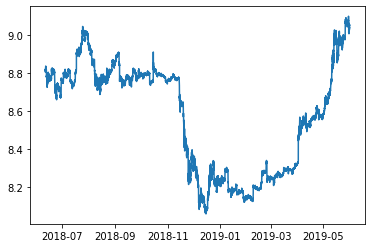

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

log_df = calc_log_prices(closes_usdt)
btc = log_df['BTCUSDT']
eth = log_df['ETHUSDT']
plt.plot(btc)

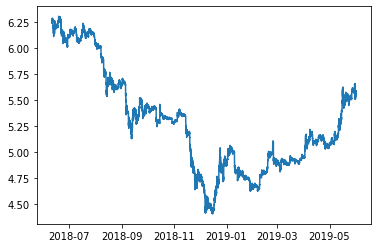

In [8]:
plt.plot(eth)

In [9]:
log_df.corr()

,BNBUSDT,LTCUSDT,TRXUSDT,ETHUSDT,BTCUSDT,EOSUSDT,ADAUSDT,XRPUSDT
BNBUSDT,1.000000,0.906205,0.578379,0.461906,0.560689,0.669280,0.570211,0.096426
LTCUSDT,0.906205,1.000000,0.727757,0.757928,0.772417,0.899883,0.839774,0.364208
TRXUSDT,0.578379,0.727757,1.000000,0.733843,0.482909,0.699370,0.741298,0.432130
ETHUSDT,0.461906,0.757928,0.733843,1.000000,0.833640,0.915164,0.963032,0.613163
BTCUSDT,0.560689,0.772417,0.482909,0.833640,1.000000,0.894747,0.854342,0.574942
EOSUSDT,0.669280,0.899883,0.699370,0.915164,0.894747,1.000000,0.946963,0.624275
ADAUSDT,0.570211,0.839774,0.741298,0.963032,0.854342,0.946963,1.000000,0.572469
XRPUSDT,0.096426,0.364208,0.432130,0.613163,0.574942,0.624275,0.572469,1.000000


## Cointegration

The goal is to know when to and when not to engage in pairs trading, so we need a measure of how well assets move together. To this end, the concept of cointegration is helpful. 

Let $y_t$ and $x_t$ be a pair of $I(1)$ non-stationary time series variables. If there is a *cointegrating factor* $\beta$ such that $y_t + \beta x_t = u_t$ where $u_t$ is a stationary process, then the two series $y_t, x_t$ are said to be cointegrated. For our purposes, $u_t$ can be considered the pricing discrepancy that we will trade on.

### Engle-Granger Two Step Method

One test to determine cointegration is known as the Engle-Granger two step method. The two steps are:

1. Estimate the regression $\hat{y_t} = \hat{\alpha} + \hat{\beta} x_t + \hat{u_t}$
2. Test the residuals $\hat{u_t}$ for a unit root

We use the Dickey-Fuller unit root test for the second step and OLS for the first.

### Cointegration between BTC and ETH

The two assets we want to inspect for cointegration are Bitcoin and Ethereum. For demonstration purposes, I have cherry-picked a period in the time series where they are indeed cointegrated and will prove it below. For the plot, I've scaled the values to be near each other.

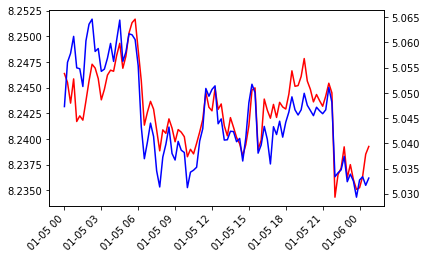

In [10]:
date = '2019-01-05'
start = int(np.where(log_df.index == date)[0])
end = int(np.where(log_df.index == date)[0] + 100)

btc = log_df['BTCUSDT'][start:end]
eth = log_df['ETHUSDT'][start:end]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(btc, color="red")
ax2.plot(eth, color="blue")
fig.autofmt_xdate(rotation=45)

To prove this is cointegrated, we do the Engle Granger approach described above

In [11]:
from sklearn.linear_model import LinearRegression

eth_array = np.array(eth).reshape(-1, 1)
btc_array = np.array(btc)

regression = LinearRegression()
regression.fit(eth_array, btc_array)
print(regression.coef_)
print(regression.intercept_)

[0.34100285]
6.522231543054636


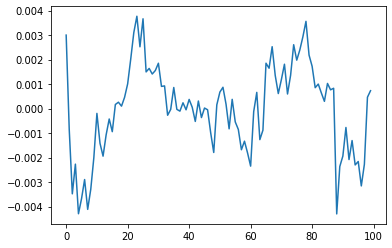

In [12]:
btc_hat = regression.predict(eth_array)
residuals = btc_array - btc_hat
plt.plot(residuals)

We can see that the residuals of the model are mean reverting, and now we test this using the Dickey Fuller test

In [13]:
import statsmodels.tsa.stattools as ts
ts.adfuller(residuals)

(-3.6553909792347588,
 0.004786215496236841,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 -947.9629448288958)

The first value is the test statistic from the Dickey Fuller test, and the second is the p-value. As we can see, the two time series are cointegrated at the 1% level.

Suppose you were partying all night and slept the entire day, so your trading started at 5:30 in the afternoon rather than midnight on 2019-01-05. At this time, we find an example of non-cointegration between BTC and ETH.

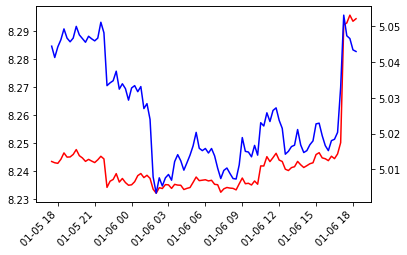

In [14]:
date = '2019-01-05 17:30:00+0000'
start = int(np.where(log_df.index == date)[0])
end = int(np.where(log_df.index == date)[0] + 100)

btc = log_df['BTCUSDT'][start:end]
eth = log_df['ETHUSDT'][start:end]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(btc, color="red")
ax2.plot(eth, color="blue")
fig.autofmt_xdate(rotation=45)

The point is that there are less cross overs with this and therefore less pair trading opportunities.

In [15]:
eth_array = np.array(eth).reshape(-1, 1)
btc_array = np.array(btc)

regression = LinearRegression()
regression.fit(eth_array, btc_array)
print(regression.coef_)
print(regression.intercept_)

[0.48359667]
5.81230086220989


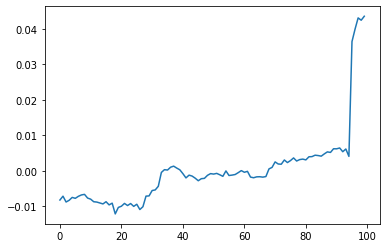

In [16]:
btc_hat = regression.predict(eth_array)
residuals = btc_array - btc_hat
plt.plot(residuals)

In [17]:
ts.adfuller(residuals)

(1.0846729767379113,
 0.9950836663843439,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 -729.7914766563806)

The residuals are clearly non-stationary with this period

## Rolling Analysis

In the above example, the period of analysis is 100 observations of 15 minute observations. The question of interest is how this data changes over time. To accomplish this, we construct both the target variable and the features for the machine learning models using a rolling calculation.

In [18]:
from core.rolling_analysis import RollingAnalyzer

m = 100

rolling_analyzer = RollingAnalyzer(log_df, m)
rolling_analyzer.make_dfs()
rolling_analyzer.make_pairs()
rolling_analyzer.run_regressions('ETHUSDT', 'BTCUSDT')
rolling_analyzer.calc_dickey_fuller('ETHUSDT', 'BTCUSDT')

### Response variable: the p-value of the Dickey Fuller Test

The goal is to identify the windows of time when the pairs trading strategy makes the most sense, so the target variable chosen is the p-value of the Dickey-Fuller test. This has already been calculated and can be exported now to a dataframe, then plotted.

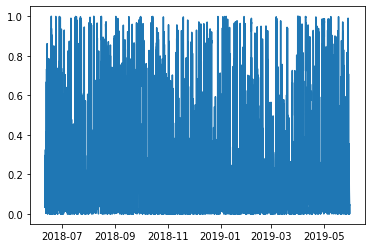

In [19]:
dickey_fuller_roll = rolling_analyzer.export_dickey_fuller_df()
plt.plot(dickey_fuller_roll)

This is clearly a mess, so I will zoom in on a shorter period of time (first week of 2019)

(array([737060., 737061., 737062., 737063., 737064., 737065., 737066.,
        737067.]), <a list of 8 Text xticklabel objects>)

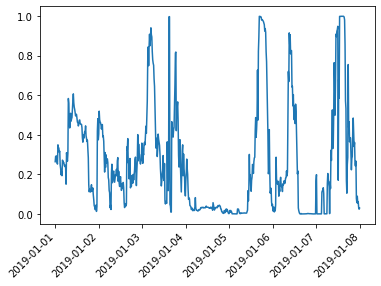

In [20]:
plt.plot(dickey_fuller_roll['2019-01-01':'2019-01-07'])
plt.xticks(rotation=45, ha='right')

Notice that value is between 0 and 1 because it is a p-value. We can transform this to be between negative infinity and infinity using the same transformation as in the logistic regression

(array([737060., 737061., 737062., 737063., 737064., 737065., 737066.,
        737067.]), <a list of 8 Text xticklabel objects>)

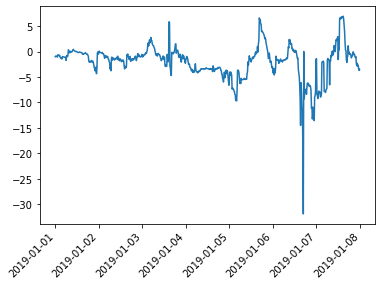

In [21]:
def to_infinity(x):
    return np.log(x/(1-x))
    
df_infinity = to_infinity(dickey_fuller_roll).replace([np.inf, -np.inf], 0)
plt.plot(df_infinity['2019-01-01':'2019-01-07'])
plt.xticks(rotation=45, ha='right')

This is the target variable we would like to forecast using machine learning.

Because this is a rolled time series, we expect autocorrelation

(0, 110)

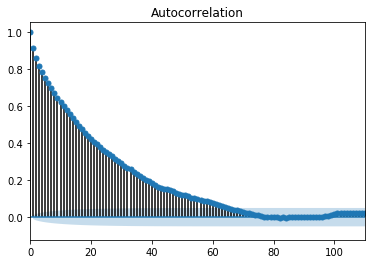

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_infinity)
plt.xlim(0, 110)

Clearly this can easily be forecast already because of the autocorrelation. However, because of the rolling, we wish to forecast the next step *by the rolling window* and not simply one observation ahead. From the autocorrelation plot, we see there is little correlation between the current p-value and the one 100 observations away.

### Feature variables: rolled statistics

We now introduce the other features besides lagged p-values for the machine learning models. These are calculated as rolled mean returns and volatility over the same period. 

In [23]:
rolling_analyzer.calc_all_returns_stats()
mean_returns_df = rolling_analyzer.export_returns_stats_df(stat='mean_return')
volatility_df = rolling_analyzer.export_returns_stats_df(stat='volatility')

(array([737060., 737061., 737062., 737063., 737064., 737065., 737066.,
        737067.]), <a list of 8 Text xticklabel objects>)

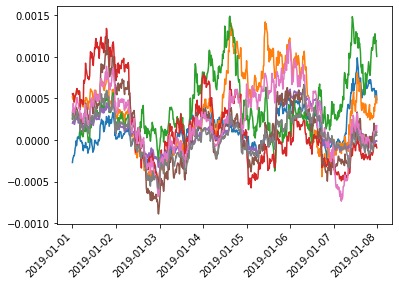

In [24]:
plt.plot(mean_returns_df['2019-01-01':'2019-01-07'])
plt.xticks(rotation=45, ha='right')

(array([737060., 737061., 737062., 737063., 737064., 737065., 737066.,
        737067.]), <a list of 8 Text xticklabel objects>)

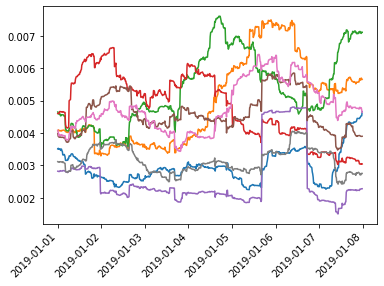

In [25]:
plt.plot(volatility_df['2019-01-01':'2019-01-07'])
plt.xticks(rotation=45, ha='right')

There are many statistics that can be generated for use as features with the rolling period - Sharpe ratio, skewness and kurtosis, correlation, etc. We can even produce the rolled cointegration measures for the other asset pairs and use that as a feature to the model. Discovering whether or not these features produce explanatory power in future cointegration is the goal of the project.

## Multivariate Forecasting and Model Performance

Unlike with the regressions we have gone over in class that predict one response variable, a time series forecast requires many simultaneous predictions. For this project, we wish to predict 100 future values based on the current state of the market, which is a considerable complication of time series modeling.

For example, we wish to predict the next hundred values at the current 15 minute $t$, predict a hundred again in 15 minutes, and so on. This means that our response variable $\hat{y}$ is in fact a matrix of response variables, $\hat{Y}$ with $T$ rows from $t=0$ to $T$ and $m$ columns from $n=1$ to $m=100$. Fortunately, scikit-learn provides a class `MultiOutputRegressor` that addresses this concern.

This introduces some interesting concerns with regard to model performance. Each row has an MSE associated with it, and then the MSE of each row can be averaged for an overall measure of model performance.

## Machine Learning: SVR
### Alex Thompson

In [26]:
import sys

project_dir = '/Users/alex/ml_class/project/'

sys.path.append(project_dir)

In [27]:
from core.rolling_analysis import RollingAnalyzer
from core.utils import get_dfs, get_good_dfs, \
get_close_prices, fix_gaps_in_data, calc_returns, \
calc_log_prices, get_pairs
from sklearn.preprocessing import FunctionTransformer

import warnings
import numpy
import pandas as pd

warnings.simplefilter(action='ignore', category=FutureWarning)
m = 100
start_date = '2019-01-01'
end_date = '2019-03-01'

print("getting data")
dfs = get_dfs(project_dir + "data")
print("filtering to good ones")
good_dfs = get_good_dfs(dfs, 30000)
print("getting close prices")
closes = get_close_prices(good_dfs)
print("filling gaps")
closes = fix_gaps_in_data(closes)
print("filtering to USDT")
pairs = get_pairs(good_dfs)
closes_usdt = closes[pairs['USD']]

print("calculating log prices")
log_df = calc_log_prices(closes_usdt)
filtered_df = log_df[start_date:end_date]

print("calculating returns")
returns = calc_returns(closes_usdt)
print("-------------------")
print("Now rolling analysis")
rolling_analyzer = RollingAnalyzer(filtered_df, m)
print("Make the dfs")
rolling_analyzer.make_dfs()
rolling_analyzer.make_pairs()
print("Running all the regressions")
rolling_analyzer.run_all_regressions()
rolling_analyzer.calc_all_returns_stats()

print("Calculating dickey fullers")
rolling_analyzer.run_regressions('ETHUSDT', 'BTCUSDT')
rolling_analyzer.calc_dickey_fuller('ETHUSDT', 'BTCUSDT')

getting data
filtering to good ones
getting close prices
filling gaps
filtering to USDT
calculating log prices
calculating returns
-------------------
Now rolling analysis
Make the dfs
Running all the regressions
('LTCUSDT', 'BNBUSDT')
('TRXUSDT', 'BNBUSDT')
('TRXUSDT', 'LTCUSDT')
('ETHUSDT', 'BNBUSDT')
('ETHUSDT', 'LTCUSDT')
('ETHUSDT', 'TRXUSDT')
('BTCUSDT', 'BNBUSDT')
('BTCUSDT', 'LTCUSDT')
('BTCUSDT', 'TRXUSDT')
('BTCUSDT', 'ETHUSDT')
('EOSUSDT', 'BNBUSDT')
('EOSUSDT', 'LTCUSDT')
('EOSUSDT', 'TRXUSDT')
('EOSUSDT', 'ETHUSDT')
('EOSUSDT', 'BTCUSDT')
('ADAUSDT', 'BNBUSDT')
('ADAUSDT', 'LTCUSDT')
('ADAUSDT', 'TRXUSDT')
('ADAUSDT', 'ETHUSDT')
('ADAUSDT', 'BTCUSDT')
('ADAUSDT', 'EOSUSDT')
('XRPUSDT', 'BNBUSDT')
('XRPUSDT', 'LTCUSDT')
('XRPUSDT', 'TRXUSDT')
('XRPUSDT', 'ETHUSDT')
('XRPUSDT', 'BTCUSDT')
('XRPUSDT', 'EOSUSDT')
('XRPUSDT', 'ADAUSDT')
Calculating dickey fullers


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def rename_columns(df, tag):
    new_column_names = [col + '_' + tag for col in df.columns]
    df.columns = new_column_names
    return df

mean_returns_df = rename_columns(rolling_analyzer.export_returns_stats_df(stat='mean_return'), 'mean')
volatility_df = rename_columns(rolling_analyzer.export_returns_stats_df(stat='volatility'), 'vol')
dickey_fuller_df = rename_columns(rolling_analyzer.export_dickey_fuller_df(), 'pval')
betas_df = rename_columns(rolling_analyzer.export_betas_df(), 'betas')

In [29]:
def zero_to_one(x):
    return np.exp(x)/(1+np.exp(x))

def to_infinity(x):
    return np.log(x/(1-x))

inf_dickey_fuller = to_infinity(dickey_fuller_df)

In [30]:
def calculate_lags(features, target, m):
    target_lags = {}
    for i in range(0, m):
        code = 'y' + str(i)
        lag = target.shift(-i).iloc[:,0]
        target_lags[code] = lag

    y = pd.concat(target_lags, axis=1)

    features_df = pd.concat(features, axis=1).dropna()
    feature_lags = []
    for i in range(0, m):
        lag_df = features_df.shift(i)
        lag_df.columns = [c + '_lag' + str(i) for c in list(features_df.columns)]
        feature_lags.append(lag_df)

    feature_lags = pd.concat(feature_lags, axis=1)
    full_df = pd.concat([feature_lags, y], axis=1).dropna()
    full_df = full_df.replace([np.inf, -np.inf], 0)
    out = {
        'full_df': full_df,
        'features': feature_lags,
        'target': y
    }
    return out

lagged_data = calculate_lags([mean_returns_df, volatility_df, inf_dickey_fuller], inf_dickey_fuller, 100)

In [31]:
def make_train_test(df, ratio = 0.2, target=['y']):
    split_point = int((1 - ratio) * df.shape[0])
    y = df[target]
    x = df.drop(target, axis=1)
    y_train = y[0:split_point]
    x_train = x[0:split_point]
    y_test = y[(split_point + 1):]
    x_test = x[(split_point + 1):]
    out = {'train': {'x': x_train, 'y': y_train},
           'test': {'x': x_test, 'y': y_test}
          }
    return out
    
full_set = make_train_test(lagged_data['full_df'], target=list(lagged_data['target'].keys()))

### Dimensionality Reduction


The dataset has an incredibly large number of features as well as 100 output target variables. I elect to use PCA to reduce *both* of these, the input $X$ matrix as well as the output $Y$ matrix.

In [260]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def rebuild_df(pca_df, pipeline):
    rebuilt_df = pd.DataFrame(pipeline.inverse_transform(pca_df))
    rebuilt_df.index = pca_df.index
    rebuilt_df.columns = ['y' + str(i) for i in range(rebuilt_df.shape[1])]
    return rebuilt_df

def do_pca_reduce(dataset):
    x_pipeline = Pipeline([
      ('scale', StandardScaler()),
      ('pca', PCA(n_components=0.9))
    ])

    y_pipeline = Pipeline([
      ('scale', StandardScaler()),
      ('pca', PCA(n_components=0.9))
    ])

    x_reduced = pd.DataFrame(x_pipeline.fit_transform(dataset['x']), index=dataset['x'].index)
    y_reduced = pd.DataFrame(y_pipeline.fit_transform(dataset['y']), index=dataset['y'].index)

    out = {
        'pipeline': {'x': x_pipeline, 'y': y_pipeline},
        'original_data': dataset,
        'reduced_data': {'x': x_reduced, 'y': y_reduced}
    }
    return out

In [261]:
pca = do_pca_reduce(full_set['train'])
print(pca['original_data']['x'].shape, pca['original_data']['y'].shape)
print(pca['reduced_data']['x'].shape, pca['reduced_data']['y'].shape)

(4369, 1700) (4369, 100)
(4369, 20) (4369, 15)


We see that the $x$ values have been reduced from 1,700 dimensions to 20 and that the $y$ variables have been reduced from 100 to 15. This means that instead of forecasting 100 future values we merely forecast 15 different values. This is computationally easier and the PCA transformation has a smoothing effect on the target variable. Here is a plot that demonstrates how the smoothing translates to the original p-value

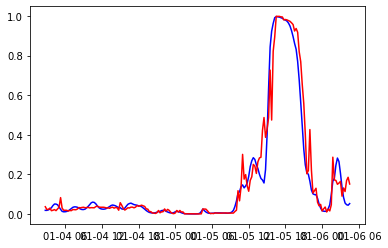

In [284]:
rebuilt_y = rebuild_df(pca['reduced_data']['y'], pca['pipeline']['y'])
plt.plot(zero_to_one(rebuilt_y.iloc[200:400,0]), color="blue")
plt.plot(zero_to_one(pca['original_data']['y'].iloc[200:400,0]), color="red")

## Support Vector Regression

My model uses support vector machines to forecast the next hundred observations. The `MultiOutputRegressor` class is used to implement the multivariate output. I do a randomized search for hyperparameter tuning.

In [239]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor

scaler = StandardScaler()

x = pca['data']['x']
y = pca['data']['y']

x_scaled = pd.DataFrame(scaler.fit_transform(x))
x_scaled.index = x.index

multioutput_model = MultiOutputRegressor(estimator=SVR())

In [240]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

tseries_split = TimeSeriesSplit(n_splits=5)
spl = tseries_split.split(x_scaled)

In [241]:
params = {
    "estimator__C": [0.1, 0.25, 0.5, 1, 2, 5, 10],
    "estimator__kernel": ['sigmoid', 'poly', 'linear']
}

randomized_search = RandomizedSearchCV(
    multioutput_model,
    param_distributions=params,
    cv=spl
)

In [242]:
randomized_search.fit(x_scaled, y)

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x1554db4f8>,
                   error_score='raise-deprecating',
                   estimator=MultiOutputRegressor(estimator=SVR(C=1.0,
                                                                cache_size=200,
                                                                coef0=0.0,
                                                                degree=3,
                                                                epsilon=0.1,
                                                                gamma='auto_deprecated',
                                                                kernel='rbf',
                                                                max_iter=-1,
                                                                shrinking=True,
                                                                tol=0.001,
                                                                verbose=False),
             

In [244]:
randomized_search.best_params_

{'estimator__kernel': 'poly', 'estimator__C': 0.5}

In [245]:
model = randomized_search.best_estimator_

In [246]:
predicted = pd.DataFrame(
    model.predict(x_scaled),
    index=full_set['train']['x'].index
)

In [282]:
rebuild_pred = rebuild_df(predicted, pca['pipeline']['y'])
rebuild_y = rebuild_df(pca['reduced_data']['y'], pca['pipeline']['y'])

Here is the plot of the original data, the smoothed PCA transform data, and the fitted prediction.

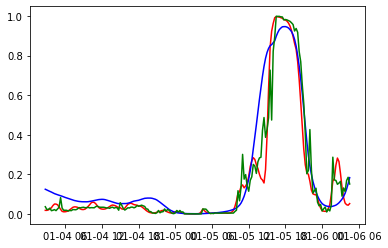

In [311]:
plt.plot(zero_to_one(rebuild_y['y0']).iloc[200:400], color="red")
plt.plot(zero_to_one(rebuild_pred['y12']).iloc[200:400], color="blue")
plt.plot(zero_to_one(pca['original_data']['y'].iloc[200:400,0]), color="green")

In [317]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(
    zero_to_one(pca['original_data']['y']),
    zero_to_one(rebuild_pred)
)

np.sqrt(mse)

0.1591080908336321

## Machine Learning: Neural Networks
### Ryan Johnson

### Setup

In [ ]:
import datetime
import json
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import numpy
from functools import reduce
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import statsmodels.tsa.stattools as ts

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
files = os.listdir("../data/")
symbols = [f[:-4] for f in files if f[-4:]==".csv"]
print(symbols)
dfs = {f[:-4]: pd.read_csv("../data/" + f, index_col="time") for f in files if f[-4:]==".csv"}

n = 30000
good_dfs = {}
for k, v in dfs.items():
    if v.shape[0] > n:
        good_dfs[k] = v

In [ ]:
for k, v in good_dfs.items():
    good_dfs[k].index = pd.to_datetime(good_dfs[k].index, unit="ms", utc=True)

closes_ls = [good_dfs[k]['close'] for k, v in good_dfs.items()]
closes_df = pd.concat(closes_ls, axis=1).dropna()
closes_df.columns = list(good_dfs.keys())
closes_df.shape

In [ ]:
bad_times = list(pd.DataFrame(closes_df.index).time.diff().unique())
[i.astype('timedelta64[m]') for i in bad_times] 

In [ ]:
closes_df = closes_df.resample('15T').max()
closes_df.fillna(method="ffill", inplace=True)
closes_df.shape # The dimensions have changed!

In [ ]:
dfs_keys = good_dfs.keys()
usd_pairs = list(filter(lambda x:  x[-4:] == 'USDT', list(dfs_keys)))
btc_pairs = list(filter(lambda x:  x[-3:] == 'BTC', list(dfs_keys)))
eth_pairs = list(filter(lambda x:  x[-3:] == 'ETH', list(dfs_keys)))
bnb_pairs = list(filter(lambda x:  x[-3:] == 'BNB', list(dfs_keys)))
pairs = {'USD': usd_pairs, 'BTC': btc_pairs, 'ETH': eth_pairs, 'BNB': bnb_pairs}

close_prices = closes_df[pairs['USD']]

In [ ]:
log_prices = FunctionTransformer(func=numpy.log).fit_transform(close_prices)
returns = pd.DataFrame(log_prices).diff()
returns.columns = close_prices.columns
returns = returns.drop(returns.index[0])
returns.corr()

### Cointegration

In [ ]:
log_df = pd.DataFrame(log_prices)
log_df.index = close_prices.index
log_df.columns = usd_pairs

n = log_df.shape[0]
m = 100

def get_cointegration(asset_1, asset_2):
    cointegrations = []

    for i in range(0, (n-m)):
        roll_df = log_df.iloc[i:(i+m), :]
        btc = roll_df[asset_1]
        eth = roll_df[asset_2]
        cointegrations.append(ts.coint(btc, eth)[1])
    
    return cointegrations

In [ ]:
%%time

if os.path.isfile("../cointegration.json"):
    with open("../cointegration.json", "r") as f:
        cointegration_mv = json.load(f)
else:
    cointegration_mv = {}
    for i in range(0, len(usd_pairs)):
        pair_i = usd_pairs[i]
        print(pair_i)
        for j in range(0, i):
            pair_j = usd_pairs[j]
            print("\t+",pair_j)
            if pair_i != pair_j:
                code = pair_i + '_' + pair_j
                print("\t\t=",code)
                cointegration_mv[code] = get_cointegration(pair_i, pair_j)
    
    json = json.dumps(cointegration_mv)
    f = open("../cointegration.json","w")
    f.write(json)
    f.close()
    
coint_df = pd.DataFrame.from_dict(cointegration_mv)
coint_df.index = log_df.index[m:]

### Create Test / Train Data

When picking our target and feature variables, we recognize the high correlation between different cryptocurrencies.

In [ ]:
returns.corr()

We believe that because the movements of different cryptocurrencies are so highly correlated, the cointegration levels of different pairs of cryptocurrencies should also be highly correlated, i.e. if one or more pairs of cryptocurrencies become cointegration, that might be a strong indicator that our target crypto pair is also becoming cointegrated.

Furthermore, we consider the autocorrelation of our target cryptocurrency pair. The idea is that pairs that are cointegrated today should be cointegrated tomorrow. Our ACF plot below tells us that cointegration seems to "linger" for at least 60 days, i.e. the p-values up to lag 60 have statistically significant correlation.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(coint_df[target_label])
plt.xlim(0, 125)

From this insight, we believe it is appropriate to use at least 100 observations of p-values to predict the next 100 observations of p-values. This way, we can be sure that our predictions (at least on the extremes) are not simply a case of spurious regression

In [ ]:
subset = coint_df.iloc[:2000, :]
target_label = 'BTCUSDT_ETHUSDT'

# default lookback is 100 obversavtions
# default lookforward is 100 obvservations
def ts_split(ts, target_label, feature_steps=100, target_steps=100):
    n_obs = len(ts) - feature_steps - target_steps + 1
        
    X = [ts[idx:idx + feature_steps].as_matrix() for idx in range(n_obs)]
    y = [ts[target_label][idx + feature_steps:idx + feature_steps + target_steps] for idx in range(n_obs)]
    
    return np.array(X), np.array(y)

X, y = ts_split(subset, target_label)
test_train_split = int(0.8 * len(X))
val_train_split = int(0.8 * test_train_split)

X_test, y_test = X[test_train_split:], y[test_train_split:]
X_train, y_train = X[:val_train_split], y[:val_train_split]
X_valid, y_valid = X[val_train_split:test_train_split], y[val_train_split:test_train_split]

### Neural Networks

In [ ]:
import tensorflow as tf
import keras

def reset_session(seed=42):
    tf.set_random_seed(seed)
    np.random.seed(seed)
    keras.backend.clear_session()

### RMSE Benchmark

Because we are using RMSE as a our scoring metric, we need a benchmark to compare our scores to. In this section, we create a dummy set of predictions where every guess is 0.5 for the p-value. This score will be our benchmrak moving forward.

In [ ]:
y_guess = (y_test+(0.5-y_test))
y_guess.shape

In [ ]:
benchmark = (mean_squared_error(y_test, y_guess))**0.5

In [ ]:
def RNN(n_hidden_layers=2, n_cells=20, batch_normalization=False, dropout=0.0):
    reset_session()
    
    print("% ============================================== %")
    print("Model Architecture:")
    for _ in range(n_hidden_layers):
        if dropout != 0.0:
            print("\t->SimpleRNN("+str(n_cells)+" cells, "+str(dropout*100)+"% dropout)")
        else: 
            print("\t->SimpleRNN("+str(n_cells)+")")
        if batch_normalization:
            print("\t->BatchNormalization()\n")
    print("\n")
    
    x_row = X.shape[1]
    x_col = X.shape[2]
    n_ahead = y.shape[1]
    
    model = keras.models.Sequential()
    for _ in range(n_hidden_layers):
        model.add(keras.layers.SimpleRNN(n_cells, return_sequences=True, dropout=dropout, recurrent_dropout=dropout))
        model.add(keras.layers.BatchNormalization())
        
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
    model.add(keras.layers.Lambda(lambda Y_pred: Y_pred[:, -n_ahead:]))
    
    def root_mean_squared_error(y_true, y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true))) 
    
    model.compile(loss=root_mean_squared_error, optimizer="nadam")
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint("hl"+str(n_hidden_layers)+"_c"+str(n_cells)+".h5", save_best_only=True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, min_delta=0.01, restore_best_weights=True)
    
    run = model.fit(X_train, y_train[..., np.newaxis], epochs=400, 
                    validation_data=(X_valid, y_valid[..., np.newaxis]), 
                    callbacks=[checkpoint_cb, early_stopping_cb])
    
    y_pred = model.predict(X_test)
    
    pd.DataFrame(run.history).plot()
    plt.title("Learning Curve")
    plt.axhline(y=benchmark, color="r", linestyle="-", label="benchmark")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()
    
    rmse = (mean_squared_error(y_test, np.squeeze(y_pred), multioutput="raw_values"))**0.5
    plt.plot([i+1 for i in range(len(rmse))], rmse)
    plt.title("Forecast Errors")
    plt.axhline(y=benchmark, color="r", linestyle="-", label="benchmark")
    plt.xlim(1, n_ahead)
    plt.ylabel("Root Mean Squared Error")
    plt.xlabel("n-ahead Forecast")
    plt.show()
    
    print("Validation Set Score: ",model.evaluate(X_valid, y_valid[..., np.newaxis]))
    print("Test Set Score: ",model.evaluate(X_test, y_test[..., np.newaxis]))
    print("\n\n")
    
    return model

We begin with a very simple model having only a single hidden layer.

In [ ]:
RNN(1, 20)

As we can see, this model strongly overfits the data and values to beat the benchmark. 

In [ ]:
RNN(3, 20)

To combat this, we increase the number of hidden layers, add batch normalization, and dropout (at 10%).

In [ ]:
model = RNN(3, 20, batch_normalization=True, dropout=0.1)

## Machine Learning: Random Forest
### Griffin Collins

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
trax1, trax2, trax3 = X_train.shape
vax1, vax2, vax3 = X_valid.shape
tax1, tax2, tax3 = X_test.shape
d2_X_train = X_train.reshape(trax1, trax2*trax3)
d2_X_valid = X_valid.reshape(vax1, vax2*vax3)
d2_X_test = X_test.reshape(tax1, tax2*tax3)

In [ ]:
from sklearn.metrics import mean_squared_error

rfr.fit(d2_X_train, y_train)

y_pred_train = rfr.predict(d2_X_train)
np.sqrt(mean_squared_error(y_pred_train, y_train))

As we can see, the RMSE decreased using the optimized model. Now I will calculate RMSE on the validation set and create some plots illustrating model performance.

In [ ]:
import matplotlib as mlp
import matplotlib.pyplot as plt

ranger = np.arange(1, len(X_train), 200)

def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    train_errors, val_errors = [], []
    for m in ranger:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14) 
    plt.xlim = (1, len(d2_X_train))
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14) 
    
plot_learning_curves(rfr, d2_X_train, y_train, d2_X_valid, y_valid)

As you can see, the model is overfitting the data fairly severely. I will attempt to remedy this.

In [ ]:
y_pred_val_org = rfr.predict(d2_X_valid)

print(np.sqrt(mean_squared_error(y_pred_val_org, y_valid)))

In [ ]:
y_pred_test_rfr = rfr.predict(d2_X_test)

In [ ]:
mse_test_rfr = mean_squared_error(y_pred_test_rfr, y_test, multioutput = 'raw_values')
rmse_test_rfr = [np.sqrt(x) for x in mse_test_rfr]
plt.plot(rmse_test_rfr)
plt.title('Forecast Errors')
plt.xlim(0, 100)
plt.ylabel("RMSE")
plt.xlabel("Periods Ahead Forecast")
plt.show()

Let's try the multi-ouptut regressor class and see how well it fits.

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

mor = MultiOutputRegressor(rfr, n_jobs = 2)
mor.fit(d2_X_train, y_train)

In [ ]:
plot_learning_curves(mor, d2_X_train, y_train, d2_X_valid, y_valid)

In [ ]:
y_train_pred_mor = mor.predict(d2_X_train)
y_valid_pred_mor = mor.predict(d2_X_valid)
print("The RMSE of the multi-output regressor model on the training set is: ", np.sqrt(mean_squared_error(y_train_pred_mor, y_train)), '\n')

print("The RMSE of the multi-output regressor model on the validation set is: ", np.sqrt(mean_squared_error(y_valid_pred_mor, y_valid)), '\n')

The overfitting looks better, but still not very good. The model also fits better. Let's try dimensionality reduction and see if that gives us a model that fits both sets better.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = .95, whiten = True)
d2_X_train_pca = pca.fit_transform(d2_X_train, y_train)
d2_X_valid_pca = pca.transform(d2_X_valid)
d2_X_test_pca = pca.transform(d2_X_test)

In [ ]:
print(d2_X_train_pca)

In [ ]:
mor_pca = MultiOutputRegressor(rfr, n_jobs = 2)
mor_pca.fit(d2_X_train_pca, y_train)

In [ ]:
plot_learning_curves(mor_pca, d2_X_train_pca, y_train, d2_X_valid_pca, y_valid)

It appears the model is still overfitting, and is overfitting even worse than before. Let's check RMSE on the validation and training set just to be sure.

In [ ]:
y_pred_train_mor_pca = mor_pca.predict(d2_X_train_pca)
mse_train_mor_pca = mean_squared_error(y_pred_train_mor_pca, y_train, multioutput = 'raw_values')
rmse_train_more_pca = [np.sqrt(x) for x in y_pred_train_mor_pca]
y_pred_valid_mor_pca = mor_pca.predict(d2_X_valid_pca)
mse_train_mor_pca = mean_squared_error(y_pred_valid_mor_pca, y_valid, multioutput = 'raw_values')
rmse_valid_more_pca = [np.sqrt(x) for x in y_pred_valid_mor_pca]
plt.plot(rmse_train_more_pca, 'r', rmse_valid_more_pca, 'b')
plt.show()

Based on this plot it seems the RMSE's are close to one another. However, I would estimate that the final RMSE values will differ more significantly

In [ ]:
print("Training set RMSE:\n")
print(np.sqrt(mean_squared_error(y_pred_train_mor_pca, y_train)), "\n")
print("Validation set RMSE:\n")
print(np.sqrt(mean_squared_error(y_pred_valid_mor_pca, y_valid)))

While the model does seem to be overfitting less, it is still overfitting. In addition to this, the predicting power of the model has decreased in both training and validation sets. Let's try fine tuning our model parameters to fit noise less frequently.

In [ ]:
rfr_tuning = RandomForestRegressor(n_estimators = 50, criterion = 'mse', min_samples_split = 50, min_samples_leaf = 50)
mod_tuned = MultiOutputRegressor(rfr_tuning, n_jobs = 2)
mod_tuned.fit(d2_X_train, y_train)

In [ ]:
plot_learning_curves(mod_tuned, d2_X_train, y_train, d2_X_valid, y_valid)

In [ ]:
y_pred_test_mod_tuned = mod_tuned.predict(d2_X_test)
mse_test_mod_tuned = mean_squared_error(y_pred_test_mod_tuned, y_test, multioutput = 'raw_values')
rmse_test_mod_tuned = [np.sqrt(x) for x in mse_test_mod_tuned]
plt.plot(rmse_test_mod_tuned)
plt.title('Forecast Errors')
plt.xlim(0, 100)
plt.ylabel("RMSE")
plt.xlabel("Periods Ahead Forecast")
plt.show()

In [ ]:
y_pred_train_mod_tuned = mod_tuned.predict(d2_X_train)
y_pred_valid_mod_tuned = mod_tuned.predict(d2_X_valid)
print("The RMSE of the tuned model on the training set is ", np.sqrt(mean_squared_error(y_pred_train_mod_tuned, y_train)), "\n")
print("The RMSE of the tuned model on the validation set is ", np.sqrt(mean_squared_error(y_pred_valid_mod_tuned, y_valid)), "\n")

The best model appears to be the untuned MultiOutput Regressor model. Let's see how it performs on the test set. It is also important to note that the tuned model fits significantly better than the untuned model, despite only a small drop in performance.

In [ ]:
y_pred_test_mor = mor.predict(d2_X_test)
print("The RMSE of the MultiOutput Regressor model on the test set is: ", np.sqrt(mean_squared_error(y_pred_test_mor,y_test )))
mse_test_mor = mean_squared_error(y_pred_test_mor, y_test, multioutput = 'raw_values')
rmse_test_mor = [np.sqrt(x) for x in mse_test_mor]
plt.plot(rmse_test_mor)
plt.title('Forecast Errors')
plt.xlim(0, 100)
plt.ylabel("RMSE")
plt.xlabel("Periods Ahead Forecast")
plt.show()

The tuned model actually performs better on the test set than the multioutput regressor model. Let's see if we can change some of the parameters for better performance.

In [ ]:
rfr_tun2 = RandomForestRegressor(n_estimators = 65,criterion = 'mse', min_samples_split = 25, min_samples_leaf = 25, max_depth = 100)
mod_tuned2 = MultiOutputRegressor(rfr_tun2, n_jobs = 2)
mod_tuned2.fit(d2_X_train, y_train)

In [ ]:
plot_learning_curves(mod_tuned2, d2_X_train, y_train, d2_X_valid, y_valid)

In [ ]:
y_pred_train_mod_tuned2 = mod_tuned2.predict(d2_X_train)
y_pred_valid_mod_tuned2 = mod_tuned2.predict(d2_X_valid)
print("The RMSE of the tuned model on the training set is ", np.sqrt(mean_squared_error(y_pred_train_mod_tuned2, y_train)), "\n")
print("The RMSE of the tuned model on the validation set is ", np.sqrt(mean_squared_error(y_pred_valid_mod_tuned2, y_valid)), "\n")
y_pred_test_mod_tuned2 = mod_tuned2.predict(d2_X_test)
print("The RMSE of the tuned model on the test set is ", np.sqrt(mean_squared_error(y_pred_test_mod_tuned2, y_test)), "\n")

In [ ]:
So the original tuned model had a better RMSE on training and test sets, So that is the model I will use.

## Conclusion